In [1]:
import os, sys
import yaml
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from jax import jit

from pybird.io_pb import save_dict_to_hdf5, get_dict_from_hdf5, h5py
from pybird.symbolic import DA, Hubble
from pybird.run import Run

from getdist import loadMCSamples, plots, mcsamples, MCSamples

import warnings
warnings.filterwarnings("ignore") # to silence CosmoPower-JAX warnings

# AbacusSummit cubic simulation cosmological analysis
- In *~minutes* on the laptop 
    - with `PyBird-JAX`, cf. [2507.20990](https://arxiv.org/abs/2507.20990), [2003.07956](https://arxiv.org/abs/2003.07956)
    - ~~combined with Boltzmann [Symbolic generator](https://github.com/DeaglanBartlett/symbolic_pofk)~~
    - combined with [CosmoPower-JAX](https://github.com/dpiras/cosmopower-jax)   (more accurate; see installation instruction below)
   

- Data: 
    - [AbacusSummit](https://arxiv.org/abs/2110.11398) simulation suite 
    - based on the [Abacus](https://arxiv.org/abs/2110.11392) $N$-body code, 
    - [HOD](https://arxiv.org/abs/2306.06319) [calibration](https://arxiv.org/abs/2306.06314) to reproduce LRG at z = 0.8, ELG at z = 1.1, and QSO at z = 1.4
    - Redshift-space galaxy power spectrum multipoles $\ell=0,2$ measured in [2404.07272](https://arxiv.org/abs/2404.07272), publicly available on [zenodo](https://zenodo.org/records/10823206); see also [2404.07283](https://arxiv.org/abs/2404.07283)
    - Mean of 25 realisations, each in a cubic box of $8 \, h^{-3} \, \textrm{Gpc}^3$, corresponding to a total of $200 \, h^{-3}\, \textrm{Gpc}^3$
    - Covariance based on the [EZmocks](https://arxiv.org/abs/1409.1124), rescaled to the total volume $V_{25} = 200 \, h^{-3}\, \textrm{Gpc}^3$
    - $[k_{\rm min}, k_{\rm max}] = [0.02, 0.18] \, h/\textrm{Mpc}$ as in [2404.07272](https://arxiv.org/abs/2404.07272), cf fig. 1

    
- Model: power spectrum of galaxies in redshift space from one-loop EFTofLSS, cf. [1610.09321](https://arxiv.org/abs/1610.09321), [1909.05271](https://arxiv.org/abs/1909.05271), [2110.00016](https://arxiv.org/abs/2110.00016)
- Priors: 
    - flat on cosmological parameters and $b_1$
    - fixed $\omega_b$ and $n_s$
    - $\mathcal{N}(0, 5)$: Gaussians centred on $0$ with standard deviation of $5$ on nonlinear EFT parameters $c_2 = (b_2 + b_4)/\sqrt{2}, b_3, c_{\rm ct}, c_{r,1}, c_{r,2}, c_{\epsilon,1}, c_{\epsilon,2}, c_{r,4}, c_{r,6}$
    - $\mathcal{N}(0, 2)$ on $c_{\epsilon,0}$ (shot noise)
    - $k_{\rm NL} = k_{\rm M} = 0.7 \, h/\textrm{Mpc} \, , \quad k_{\rm R} = 0.25 \, h/\textrm{Mpc} \, , \quad \bar n = 3/5/1 \cdot 10^{-4} \, (\textrm{Mpc}/h)^3$ (LRG/ELG/QSO) 

 - To install `CosmoPower-JAX` custom with one neutrino compatible with `PyBird-JAX`, 
    - `git clone https://github.com/dpiras/cosmopower-jax.git`
    - `cd cosmpower_jax`
    - `pip install -e .`
    - `cd cosmopower_jax/trained_models`
    - `git clone https://github.com/cosmopower-organization/mnu.git`
    - perhaps: `pip install tensorflow`

## Abacus mock data
format into dict and save into .h5 data file for **PyBird**

In [2]:
_datapath = os.path.join(os.path.expanduser('~'), 'github', 'pybird', 'data', 'abacus', '2404.07272')

In [3]:
def get_sky_dict(z, Omega_m_fid, pk_filename, cov_filename, datapath=_datapath):

    p0, p2 = np.loadtxt(os.path.join(datapath, '%s.txt') % pk_filename, unpack=True, usecols=(1,2))
    kk = np.loadtxt(os.path.join(_datapath, 'ELG', 'abacus_cubic_ELG_mean_ell02.txt'), unpack=True, usecols=(0,)) # k_centers (while in LRG/QSO files k_eff): we will bin the theory model around k_centers
    dk = 0.005
    pk = np.array([p0, p2, np.zeros_like(p0)]) # add hexadecapole = 0
    nk = kk.shape[0]
    
    cov = np.zeros((3*nk, 3*nk)) 
    cov[:2*nk, :2*nk] = np.loadtxt(os.path.join(datapath, '%s.txt') % cov_filename)
    if 'V1' in cov_filename: cov /= 25.
    elif 'V25' in cov_filename: pass
    nsims = 1000 # EZmocks
    
    kmask = np.where((kk <= 0.4) & (kk >= 0.005))[0]
    xmask = np.concatenate((kmask, kmask + nk, kmask + 2*nk))
    cov = cov[xmask.reshape(-1,1), xmask]
    kk = kk[kmask]
    pk = pk[:, kmask]

    H_AP, D_AP = Hubble(Omega_m_fid, z), DA(Omega_m_fid, z) 
    
    sky = { 
       'z': {'min': z, 'max': z, 'eff': z}, 
       'fid': {'Omega_m': Omega_m_fid, 'H': H_AP,  'D': D_AP}, 
       'bPk': {'multipole': 3, 'x': kk, 'l0': pk[0], 'l2': pk[1], 'l4': pk[2], 'cov': cov, 'nsims': nsims, 'binsize': dk },
        }
    
    sky['bPk']['survey_mask'] = float('nan')
    
    return sky

### Mock specifications

In [4]:
cosmo_abacus = {'omega_b': 0.02237, 'omega_cdm': 0.120, 'h': 0.6736, 'ln10^{10}A_s': 3.0364, 'n_s': 0.9649, 'm_ncdm': 0.06442}


In [5]:
def get_Omega_m(cosmo):
    return (cosmo['omega_cdm'] + cosmo['omega_b'] + cosmo['m_ncdm']/93.14) / cosmo['h']**2

Omega_m_fid = get_Omega_m(cosmo_abacus)

In [6]:
spec = {}

spec['LRG'] = {'z': 0.8, 'Omega_m_fid': Omega_m_fid, 
             'pk_filename': 'abacus_cubic_LRG_mean_ell02_data', 
             'cov_filename': 'abacus_cubic_LRG_covariance_V25',
             'datapath': os.path.join(_datapath, 'LRG')}

spec['ELG'] = {'z': 1.1, 'Omega_m_fid': Omega_m_fid, 
             'pk_filename': 'abacus_cubic_ELG_mean_ell02', 
             'cov_filename': 'abacus_cubic_ELG_covariance_V1',
             'datapath': os.path.join(_datapath, 'ELG')}

spec['QSO'] = {'z': 1.4, 'Omega_m_fid': Omega_m_fid, 
             'pk_filename': 'abacus_cubic_QSO_mean_ell02', 
             'cov_filename': 'abacus_cubic_QSO_covariance_ell02_V1',
             'datapath': os.path.join(_datapath, 'QSO')}

In [7]:
data = {key: get_sky_dict(**val) for key, val in spec.items()}

In [8]:
filename = os.path.join(os.path.expanduser('~'),  'github', 'pybird', 'data', 'abacus', 'abacus.h5')
with h5py.File(filename, 'w') as hf: save_dict_to_hdf5(hf, data)

## Cosmological analysis

path

In [9]:
rootdir = os.path.join(os.path.expanduser('~'), 'github', 'pybird')
datadir = os.path.join(rootdir, 'data', 'abacus')
outdir = os.path.join(datadir, 'out')

run config

In [10]:
configname = 'run_abacus'
run_config = yaml.full_load(open(os.path.join(datadir, 'run_config', '%s.yaml') % configname, 'r'))

# run_config['boltzmann'] = 'Symbolic' 
run_config['boltzmann'] = 'CPJ_custom' 

run_config['free_cosmo_name'] = ['omega_cdm', 'h', 'ln10^{10}A_s']
run_config['fiducial_cosmo'] = cosmo_abacus

print(yaml.dump(run_config, indent=4, sort_keys=False))

free_cosmo_name:
- omega_cdm
- h
- ln10^{10}A_s
fiducial_cosmo:
    omega_b: 0.02237
    omega_cdm: 0.12
    h: 0.6736
    ln10^{10}A_s: 3.0364
    n_s: 0.9649
    m_ncdm: 0.06442
jax_jit: true
taylor: true
vectorize: true
boltzmann: CPJ_custom
minimizers:
- minuit
- minuit
samplers:
- fisher
- emcee



In [11]:
simnames = ['LRG', 'ELG', 'QSO']

likelihood_configs = {simname: yaml.full_load(open(os.path.join(datadir, 'likelihood_config', '%s.yaml') % simname, 'r')) 
                      for simname in simnames}

# print ( yaml.dump(likelihood_configs[0], indent=4, sort_keys=False))

In [12]:
emcee_options =  {'num_samples': 20000, 'discard': 2000, 'thin': 30, 'n_walkers': 16} 

In [13]:
def get_samples(likelihood_config):
    R = Run(run_config, likelihood_config, outdir, verbose=True)
    R.c.update({'emulate': False, 'taylor': False}) # no emu nor Taylor when minimising to ensure accurate point estimates
    mode = R.run(minimizers=['minuit'], output=True, plot_bestfit=True, verbose=True) 
    R.c.update({'emulate': True, 'taylor': True})  # accelerating before sampling
    samples = R.run(samplers=['fisher', 'emcee'] , output=True, samplers_options=[{}, emcee_options], return_extras=True, verbose=True)
    return mode, samples

free_cosmo_name: ['omega_cdm', 'h', 'ln10^{10}A_s']
fiducial_cosmo: {'omega_b': 0.02237, 'omega_cdm': 0.12, 'h': 0.6736, 'ln10^{10}A_s': 3.0364, 'n_s': 0.9649, 'm_ncdm': 0.06442}
cosmo_prior: False
ext_probe: False
ext_loglkl: None
measure: False
taylor_measure: False
debiasing: False
hessian_type: None
vectorize: True
emulate: None
taylor: True
jax_jit: True
order: 3
boltzmann: CPJ_custom
'vectorize' or 'taylor' is True, setting 'jax_jit' to True
jax: on
reading data file: ../data/abacus/abacus.h5
-----------------------
sky: LRG
output: bPk
multipole: 2
min bound (per multipole): [0.02, 0.02]
max bound (per multipole): [0.18, 0.18]
coordinate (AP) distortion: on
binning: on
-----------------------
LRG: Hartlap factor correction on precision matrix estimated from 1000 mocks for 64 bins
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : False
drop_logdet : False
cache : False
-----------------------
----- minimisation with minuit -----
Em

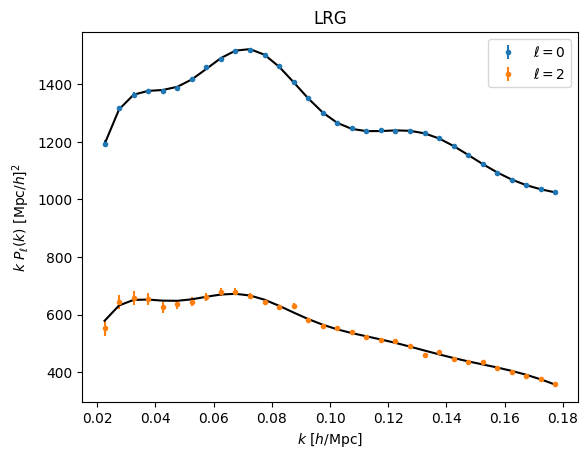

--------------------------------
----- sampling with fisher -----
Emulator: on
Taylor: expanding cosmology-dependent correlator pieces...
Taylor: best-fit values found --- using them as fiducials
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, in case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceve

100%|██████████| 20000/20000 [00:20<00:00, 960.20it/s] 


autocorr time:  [57. 52. 63. 68. 76.]
sampling done in 21.227 sec.
--------------------------------
free_cosmo_name: ['omega_cdm', 'h', 'ln10^{10}A_s']
fiducial_cosmo: {'omega_b': 0.02237, 'omega_cdm': 0.12, 'h': 0.6736, 'ln10^{10}A_s': 3.0364, 'n_s': 0.9649, 'm_ncdm': 0.06442}
cosmo_prior: False
ext_probe: False
ext_loglkl: None
measure: False
taylor_measure: False
debiasing: False
hessian_type: None
vectorize: True
emulate: None
taylor: True
jax_jit: True
order: 3
boltzmann: CPJ_custom
'vectorize' or 'taylor' is True, setting 'jax_jit' to True
jax: on
reading data file: ../data/abacus/abacus.h5
-----------------------
sky: ELG
output: bPk
multipole: 2
min bound (per multipole): [0.02, 0.02]
max bound (per multipole): [0.18, 0.18]
coordinate (AP) distortion: on
binning: on
-----------------------
ELG: Hartlap factor correction on precision matrix estimated from 1000 mocks for 64 bins
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : Fal

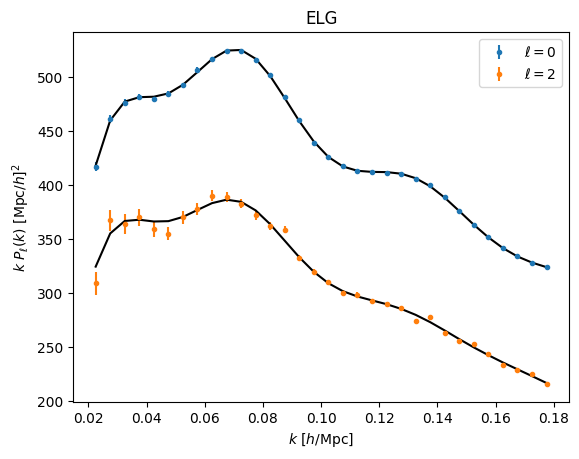

--------------------------------
----- sampling with fisher -----
Emulator: on
Taylor: expanding cosmology-dependent correlator pieces...
Taylor: best-fit values found --- using them as fiducials
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, in case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceve

100%|██████████| 20000/20000 [00:21<00:00, 933.78it/s] 


autocorr time:  [ 71.  78.  73.  79. 104.]
sampling done in 21.881 sec.
--------------------------------
free_cosmo_name: ['omega_cdm', 'h', 'ln10^{10}A_s']
fiducial_cosmo: {'omega_b': 0.02237, 'omega_cdm': 0.12, 'h': 0.6736, 'ln10^{10}A_s': 3.0364, 'n_s': 0.9649, 'm_ncdm': 0.06442}
cosmo_prior: False
ext_probe: False
ext_loglkl: None
measure: False
taylor_measure: False
debiasing: False
hessian_type: None
vectorize: True
emulate: None
taylor: True
jax_jit: True
order: 3
boltzmann: CPJ_custom
'vectorize' or 'taylor' is True, setting 'jax_jit' to True
jax: on
reading data file: ../data/abacus/abacus.h5
-----------------------
sky: QSO
output: bPk
multipole: 2
min bound (per multipole): [0.02, 0.02]
max bound (per multipole): [0.18, 0.18]
coordinate (AP) distortion: on
binning: on
-----------------------
QSO: Hartlap factor correction on precision matrix estimated from 1000 mocks for 64 bins
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg 

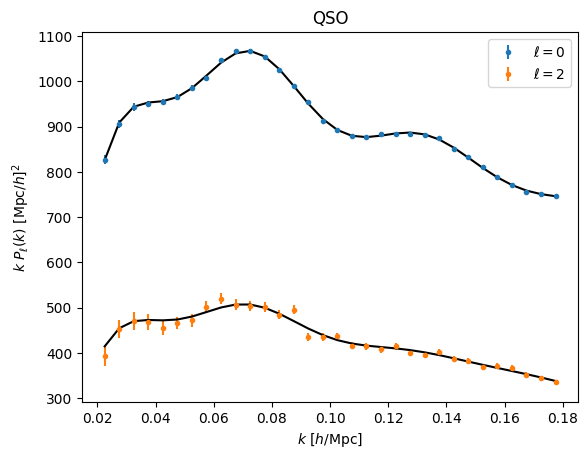

--------------------------------
----- sampling with fisher -----
Emulator: on
Taylor: expanding cosmology-dependent correlator pieces...
Taylor: best-fit values found --- using them as fiducials
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, in case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceve

100%|██████████| 20000/20000 [00:21<00:00, 935.20it/s] 


autocorr time:  [55. 57. 45. 50. 94.]
sampling done in 21.759 sec.
--------------------------------


In [14]:
modes, samples = {}, {}
for name, likelihood_config in likelihood_configs.items():
    modes[name], samples[name] = get_samples(likelihood_config)

### Results

Get derived parameters and plot

In [15]:
if run_config['boltzmann'] == 'CPJ_custom':

    from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ
    from jax.numpy import array

    _cosmo = {key: array([cosmo_abacus[key]]) for key in ["omega_b", "omega_cdm", "n_s", "ln10^{10}A_s", "m_ncdm"]}
    _cosmo['H0'] = array([cosmo_abacus['h'] * 100.])

    M = CPJ(probe='custom', filename=os.path.join('mnu', 'growth-and-distances', 'S8Z_mnu_v1.npz'))

    @jit
    def get_derived(free_cosmo): 
        _cosmo.update({key: array([val]) for key, val in zip(run_config['free_cosmo_name'], free_cosmo)})
        _cosmo['H0'] = _cosmo['h'] * 100.
        sigma_8 = M.predict(_cosmo)[0] # sigma_8(z = 0)
        Omega_m = get_Omega_m(_cosmo)
        return Omega_m[0], _cosmo['h'][0], sigma_8

elif run_config['boltzmann'] == 'Symbolic':

    from pybird.symbolic import Symbolic

    S = Symbolic(max_precision=True)
    cosmo_ = deepcopy(run_config['fiducial_cosmo'])

    @jit
    def get_derived(free_cosmo):
        cosmo_.update({key: val for key, val in zip(run_config['free_cosmo_name'], free_cosmo)})
        S.set(cosmo_)
        return S.c['Omega_m'], S.c['h'], S.c['sigma_8']

cosmo_fiducial = get_derived([cosmo_abacus[key] for key in run_config['free_cosmo_name']]) # jitting
print (cosmo_fiducial)

Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, in case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
(Array(0.31529644, dtype=float64), Array(0.6736, dtype=float64), Array(0.80664789, dtype=float64))


In [16]:
cosmo_names, cosmo_labels = ['Omega_m', 'h', 'sigma_8'], [r'\Omega_m', r'h', r'\sigma_8']

def get_MCSamples(samples, sampler='emcee'): 
    names, labels = samples[sampler]['free parameters'], samples[sampler]['free parameters']
    cosmo_indices = [i for i, val in enumerate(names) if val in run_config['free_cosmo_name']]
    cosmo_samples = samples[sampler]['samples'][:,cosmo_indices] # cosmological parameters
    derived_cosmo_samples = np.array([get_derived(s) for s in cosmo_samples])
    return MCSamples(samples=derived_cosmo_samples, names=cosmo_names, labels=cosmo_labels)

In [17]:
names = modes[simnames[0]]['minuit']['free parameters']
cosmo_indices = [i for i, val in enumerate(names) if val in run_config['free_cosmo_name']]
all_modes = {simname: get_derived(mode['minuit']['bestfit'][cosmo_indices]) for simname, mode in modes.items()}

all_samples = {simname: get_MCSamples(s) for simname, s in samples.items()}

Removed no burn in
Removed no burn in
Removed no burn in


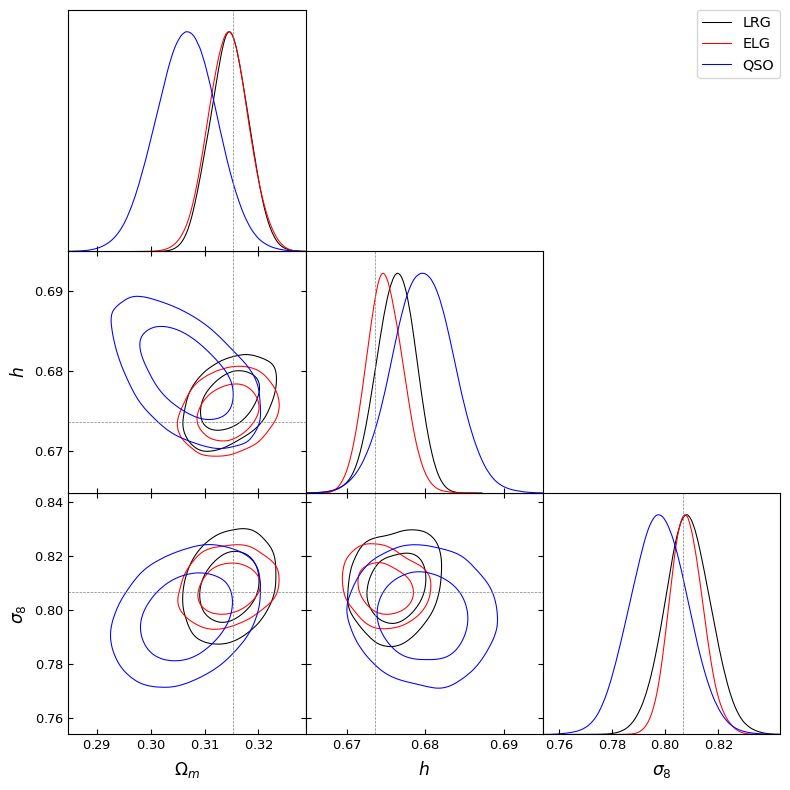

In [18]:
%matplotlib inline 
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([s for s in all_samples.values()], 
                cosmo_names, markers=cosmo_fiducial, 
                legend_labels=[name for name in all_samples.keys()])
plt.show()

In [19]:
print(f"{'Param    [truth]':<18} " + "  ".join(f"{r'[%s] mode (bias/σ) mean σ (bias/σ)':<36}" % label for label in simnames))
print('-' * (20 + len(all_samples) * 40))

for i, p in enumerate(cosmo_names):
    truth = cosmo_fiducial[i]
    row = f"{p:<8} [{truth:5.3f}]"
    for m, s in zip(all_modes.values(), all_samples.values()):
        stats = s.getMargeStats().parWithName(p)
        mu, std = stats.mean, stats.err
        row += f"{m[i]:8.3f} ({(m[i]-truth)/std:4.1f}) {mu:8.3f} {std:6.3f} ({(mu-truth)/std:4.1f})  "
    print(row)

Param    [truth]   [LRG] mode (bias/σ) mean σ (bias/σ)    [ELG] mode (bias/σ) mean σ (bias/σ)    [QSO] mode (bias/σ) mean σ (bias/σ)  
--------------------------------------------------------------------------------------------------------------------------------------------
Omega_m  [0.315]   0.315 (-0.1)    0.315  0.004 (-0.2)     0.314 (-0.3)    0.314  0.004 (-0.2)     0.308 (-1.2)    0.307  0.006 (-1.5)  
h        [0.674]   0.676 ( 1.0)    0.676  0.002 ( 1.1)     0.674 ( 0.2)    0.675  0.002 ( 0.5)     0.679 ( 1.5)    0.680  0.004 ( 1.6)  
sigma_8  [0.807]   0.808 ( 0.1)    0.809  0.009 ( 0.2)     0.809 ( 0.3)    0.808  0.006 ( 0.2)     0.797 (-0.9)    0.798  0.011 (-0.8)  


In [ ]:
### Results with CPJ_custom
# Param    [truth]   [LRG] mode (bias/σ) mean σ (bias/σ)    [ELG] mode (bias/σ) mean σ (bias/σ)    [QSO] mode (bias/σ) mean σ (bias/σ)  
# --------------------------------------------------------------------------------------------------------------------------------------------
# Omega_m  [0.315]   0.315 (-0.1)    0.315  0.004 (-0.2)     0.314 (-0.3)    0.314  0.004 (-0.2)     0.308 (-1.2)    0.307  0.006 (-1.5)  
# h        [0.674]   0.676 ( 1.0)    0.676  0.002 ( 1.1)     0.674 ( 0.2)    0.675  0.002 ( 0.5)     0.679 ( 1.5)    0.680  0.004 ( 1.6)  
# sigma_8  [0.807]   0.808 ( 0.1)    0.809  0.009 ( 0.2)     0.809 ( 0.3)    0.808  0.006 ( 0.2)     0.797 (-0.9)    0.798  0.011 (-0.8)  

### Results with Symbolic Boltzmann
# Param    [truth]   [LRG] mode (bias/σ) mean σ (bias/σ)    [ELG] mode (bias/σ) mean σ (bias/σ)    [QSO] mode (bias/σ) mean σ (bias/σ)  
# --------------------------------------------------------------------------------------------------------------------------------------------
# Omega_m  [0.315]   0.314 (-0.3)    0.314  0.004 (-0.4)     0.314 (-0.3)    0.314  0.004 (-0.2)     0.306 (-1.7)    0.305  0.006 (-1.8)  
# h        [0.674]   0.677 ( 1.6)    0.677  0.002 ( 1.7)     0.675 ( 0.8)    0.676  0.002 ( 1.2)     0.681 ( 2.2)    0.681  0.004 ( 2.1)  
# sigma_8  [0.808]   0.801 (-0.8)    0.803  0.008 (-0.7)     0.803 (-0.9)    0.803  0.006 (-0.9)     0.797 (-1.0)    0.799  0.011 (-0.9)  